In [64]:
import numpy as np
import pandas as pd
# %matplotlib inline 
import pandas as pd
import numpy as np
import rdkit.Chem.Fragments as Fragments
import torch, gpytorch
# df = pd.read_csv(r'./flav/flavone_clean_60K_smi_pcs.csv')
Xtestsmi= pd.read_csv(r'./flav/flavone_xremain_smi_clean_60K_smi_pcs.csv')
Xtest = pd.read_csv(r'./flav/flavone_xremain_clean_60K_pcs.csv')

ytrain=pd.read_csv(r'./flav/flavone_ytrain_clean_60K_smi_pcs.csv')
Xtrain=pd.read_csv(r'./flav/flavone_xtrain_clean_60K_pcs.csv')
Xtrainsmi=pd.read_csv(r'./flav/flavone_xtrain_clean_60K_smi_pcs.csv')

print(Xtest.shape,Xtestsmi.shape)
print(ytrain.shape,Xtrain.shape,Xtrainsmi.shape)

(60152, 36) (60152, 1)
(100, 3) (100, 36) (100, 1)


In [77]:
ytrain[Xtrainsmi.duplicated(subset="SMILES")]

,SMILES,delEsol,delEoxi


In [78]:
Xtrainsmi[Xtrainsmi.duplicated(subset="SMILES")]

,SMILES


In [79]:
try:
    is_smi_consistent=all(ytrain.SMILES==Xtrainsmi.SMILES)
    print("SMILES in Xtrain_smi and df_Ytrain are consistent, code will proceed smoothly")
except ValueError:
    is_smi_consistent=False
    print(f"Xtrain shape = {Xtrainsmi.shape}, Ytrain shape = {ytrain.shape}")
    print("Do DFT and Update Ytrain, or Check SMILES order in Xtrain_smi and Ytrain")
    import sys
    sys.exit(0)
    # break

SMILES in Xtrain_smi and df_Ytrain are consistent, code will proceed smoothly


In [80]:
natom_layer = Xtest.shape[1]

print(natom_layer)

36


In [81]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C ,WhiteKernel as Wht,Matern as matk
#from celluloid import Camera
from IPython.display import HTML
from copy import copy
import time
# from multiprocessing.pool import Pool
from functools import partial

def gpregression(Xtrain,Ytrain,Nfeature):    
    cmean=[1.0]*natom_layer
    cbound=[[1e-3, 1e3]]*natom_layer
    kernel = C(1.0, (1e-3,1e3)) * matk(cmean,cbound,1.5) + Wht(1.0, (1e-3, 1e3))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=40, normalize_y=False)
    gp.fit(Xtrain, Ytrain)
    return gp

#predict result using GP regression model
def gprediction(gpnetwork,xtest):
    y_pred, sigma = gpnetwork.predict(xtest, return_std=True)
    return y_pred, sigma

#compute expected improvement
def computeExpI(ypred,sigma):
    if sigma>0:
        zzval=itag*(ypred-ybest)/float(sigma)
        expI1 = itag*(ypred-ybest-epsilon)*norm.cdf(zzval)+sigma*norm.pdf(zzval)    
    else:
        expI1 = 0.
    return expI1

def expectedimprovement(xdata,gpnetwork,ybest,itag,epsilon,idx):
    ye_pred, esigma = gprediction(gpnetwork, xdata)
    # pool = Pool() 
    pairs = list(zip(ye_pred, esigma)) 
    # expItemp = pool.starmap(computeExpI, pairs) # For some reason this returns a list of 3 values 
    # expIarr = np.array(expItemp)
    expIarr = np.array(computeExpI)
    expI = expIarr[:,idx]
    return expI

def paretoSearch(capP,search='min'):
    # Non-do
    # 
    # ated sorting
    paretoIdx=[]
    F0 = []
    for i,p in enumerate(capP):
        Sp = []
        nps = 0
        for j,q in enumerate(capP):
            if i!=j:
                if search=='min':
                    compare = p < q
                elif search=='max':
                    compare = p > q
                if any(compare):
                    Sp.append(q)
                else: 
                    nps+=1
        if nps==0:
            paretoIdx.append(i)
            prank = 1
            F0.append(p.tolist())
    F0 = np.array(F0)
    return F0, paretoIdx


def paretoSearchBig(capP,searchBig='min'):
    start_timeParetoSearchBig = time.time()
    batch_size = 1000
    print(capP.shape[0])
    # Multiprocessing
    # pool = Pool()
    if capP.shape[0]<=batch_size:
        F0, paretoIdx = paretoSearch(capP, search=searchBig)
    else:
        n_parts = int(capP.shape[0]//batch_size)
        print('Total number of parts = ',n_parts)
        rem = capP.shape[0] % batch_size  
        FList = [] 
        for capP_subset in [capP[batch_size * i:batch_size * (i + 1)] for i in range(n_parts)]:
            Fi, paretoIdxi = paretoSearch(capP_subset, search=searchBig)
            FList.append(Fi)
        # for Fi,paretoIdxi in pool.map(partial(paretoSearch,search=searchBig),[capP[batch_size*i:batch_size*(i+1)] for i in range(n_parts)]):
        #     FList.append(Fi)
        if rem>0:
            Fi, paretoIdxi = paretoSearch(capP[batch_size*n_parts-1:-1], search=searchBig)
            FList.append(Fi)
            
        F1 = np.concatenate(FList)
        
        if F1.shape[0]<=batch_size:
            F0, paretoIdxTemp = paretoSearch(F1, search=searchBig)
        else:
            n_parts = int(F1.shape[0]//batch_size)
            print('Total number of parts = ',n_parts)
            rem = F1.shape[0] % batch_size  
            FList = [] 

            for i in range(n_parts):
                Fi, paretoIdxi = paretoSearch(F1[batch_size*i:batch_size(i+1)], search=searchBig)
                FList.append(Fi)

            # for Fi,paretoIdxi in pool.map(partial(paretoSearch,search=searchBig),[F1[batch_size*i:batch_size*(i+1)] for i in range(n_parts)]):
            #     FList.append(Fi)
            if rem>0:
                Fi, paretoIdxi = paretoSearch(F1[batch_size*n_parts-1:-1], search=searchBig)
                FList.append(Fi)
            F1 = np.concatenate(FList)  # New F1
            F0, paretoIdxTemp = paretoSearch(F1, search=searchBig)
            
        paretoIdx=[]
        for a in paretoIdxTemp:
            matchingArr = np.where(capP==F1[a])[0]
            counts = np.bincount(matchingArr)
            pt = np.argmax(counts)
            paretoIdx.append(pt)
    print('Finished finding BIG pareto front in ',time.time()-start_timeParetoSearchBig)
    return F0, paretoIdx


def paretoOpt(capP, metric='crowdingDistance',opt='min'):
    batch_size = 1000.
    if capP.shape[0]<=batch_size:
        F0, paretoIdx = paretoSearch(capP, search=opt)
    else:
        n_parts = int(capP.shape[0]//batch_size)
        rem = capP.shape[0] % batch_size  
        FList = [] 
        paretoIdxList = []
        for i in range(n_parts):
            Fi, paretoIdxi = paretoSearch(capP[batch_size*i:batch_size*(i+1)], search=opt)
            FList.append(Fi)
            ar_paretoIdxi = np.array(paretoIdxi)+batch_size*i
            paretoIdxList.append(ar_paretoIdxi.tolist())  
        if rem>0:
            Fi, paretoIdxi = paretoSearch(capP[batch_size*n_parts-1:-1], search=opt)
            FList.append(Fi)
            ar_paretoIdxi = np.array(paretoIdxi)+batch_size*n_parts
            paretoIdxList.append(ar_paretoIdxi.tolist())  
            
        F1 = np.concatenate(FList)
        
        paretoIdx1=np.concatenate(paretoIdxList)
        F0, paretoIdxTemp = paretoSearch(F1, search=opt)
        
        paretoIdx=[]
        for a in paretoIdxTemp:
            matchingArr = np.where(capP==F1[a])[0]
            counts = np.bincount(matchingArr)
            pt = np.argmax(counts)
            paretoIdx.append(pt)

    m=F0.shape[-1]
    l = len(F0)

    ods = np.zeros(np.max(paretoIdx)+1)
    if metric == 'crowdingDistance':
        infi = 1E6
        for i in range(m):
            order = []
            sortedF0 = sorted(F0, key=lambda x: x[i])
            for a in sortedF0: 
                matchingArr = np.where(capP==a)[0]
                counts = np.bincount(matchingArr)
                o = np.argmax(counts)
                order.append(o)
            ods[order[0]]=infi
            ods[order[-1]]=infi
            fmin = sortedF0[0][i]
            fmax = sortedF0[-1][i]
            for j in range(1,l-1):
                ods[order[j]]+=(capP[order[j+1]][i]-capP[order[j-1]][i])/(fmax-fmin)
        # Impose criteria on selecting pareto points
        if min(ods[np.nonzero(ods)])>=infi:
            bestIdx = np.argmax(ods)
        else:
            if l>2: # if there are more than 2 pareto points, pick inner points with largest crowding distance (i.e most isolated)
                tempOds=copy(ods)
                for i,a in enumerate(tempOds):
                    if a>=infi: tempOds[i]=0.
                bestIdx = np.argmax(tempOds)
            else: #pick pareto point with lower index
                bestIdx = np.argmax(ods)
    elif metric == 'euclideanDistance':  # To the hypothetical point of the current data
        for i in range(m):
            order = []
            sortedF0 = sorted(F0, key=lambda x: x[i])
            for a in sortedF0:
                matchingArr = np.where(capP==a)[0]
                counts = np.bincount(matchingArr)
                o = np.argmax(counts)
                order.append(o)          
            fmin = sortedF0[0][i]
            fmax = sortedF0[-1][i]
            for j in range(0,l):
                ods[order[j]]+=((capP[order[j]][i]-fmax)/(fmax-fmin))**2
        ods = np.sqrt(ods)
        for i,a in enumerate(ods):
            if a!=0: print(i,a)
        bestIdx = np.where(ods==np.min(ods[np.nonzero(ods)]))[0][0]
    return paretoIdx,bestIdx


In [82]:
def gpregression_pytorch(X_train,y_train,num_iter=200,learning_rate=0.1,verbose=False):
    
    """
    Gaussian Process Regression implementation with the GPyTorch
    
    Input: gpregression_pytorch(X_train,y_train,num_iter,learning_rate)
    
    Retrun: trained_model, trained_likelihood

    """
    nfeatures=X_train.shape[1]
    train_x=torch.from_numpy(np.array(X_train))
    train_y=torch.from_numpy(np.array(y_train))
    torch.set_default_dtype(torch.float64)

    # We will use the simplest form of GP model, exact inference
    class ExactGPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean() 
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))

        
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    # this is for running the notebook in our testing framework
    import os
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else num_iter


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer # for hyperparameter tuning
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=learning_rate)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if verbose*1*((i+1)%50==0 or i==0):
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (i + 1, training_iter, loss.item(),model.covar_module.base_kernel.lengthscale.item(),model.likelihood.noise.item()))
            # print('Iter %d/%d - Loss: %.3f    noise: %.3f' % (i + 1, training_iter, loss.item(),model.likelihood.noise.item()))
        optimizer.step()

    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    return model,likelihood


def gprediction_pytorch(model,likelihood,X_test):
    
    """
    Gaussian Process Predictions with gpr_pytorch
    
    Use: 
    model, likelihood = gpregression_pytorch(X_train,y_train,num_iter=200,learning_rate=0.1)  
    ypred, ysigma = gprediction__pytorch(model,likelihood,X_test)

    Return: ypred and ysigma numpy arrays
    
    """
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.from_numpy(np.array(X_test))
        torch.set_default_dtype(torch.float64)
        observed_pred = likelihood(model(test_x))
        ypred = observed_pred.mean.numpy()
        ysigma = observed_pred.stddev.numpy()
    return ypred,ysigma

def gpregression_feat(Xtrain,Ytrain,Nfeature):    
    # cmean=1.0
    # cbound=[1e-3, 1e3]
    cmean=[1.0]*Nfeature
    cbound=[[1e-3, 1e3]]*Nfeature
    kernel = C(1.0, (1e-3,1e3)) * matk(cmean,cbound,1.5) + Wht(1.0, (1e-3, 1e3))  # Matern kernel
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30, normalize_y=False)
    gpr.fit(Xtrain, Ytrain)
    return gpr

def expectedimprovement_pytorch(xdata,gp_model,gp_likelihood,ybest,itag,epsilon):

    ye_pred, esigma = gprediction_pytorch(model=gp_model,likelihood=gp_likelihood,X_test=xdata)
    expI = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            zzval=itag*(ye_pred[ii]-ybest)/float(esigma[ii])
            expI[ii]=itag*(ye_pred[ii]-ybest-epsilon)*norm.cdf(zzval)+esigma[ii]*norm.pdf(zzval)
        else:
            expI[ii]=0.0
    return expI


In [83]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import os, sys
from ase.io import read, write

def mkGaussianInputScriptNeutral(comName,fragment,charge,mult):
    file = open(comName+'.com', 'w')
    file.write("""%mem=16GB \n""")   
    file.write("""%chk="""+comName+""".chk \n""")
    file.write("""#p """+method+"""/"""+basis+""" opt(MaxCycles=200) scf(xqc,MaxConventional=200) scrf(smd,solvent=acetonitrile) \n\n""")
    file.write(fragment+""" """+str(charge)+""" """+str(mult)+"""\n\n""")
    file.write(str(charge)+""" """+str(mult)+"""\n""")
    for i, atom in enumerate(atoms):
        file.write(atom.symbol + '\t'+str(atom.position[0]) +
                  '\t\t'+str(atom.position[1]) +
                  '\t\t'+str(atom.position[2]) + '\n')
    file.write('\n')
    
    
def mkGaussianInputScriptAnion1(comName,fragment,charge,mult):
    file = open(comName+'.com', 'w')
    file.write("""%mem=16GB \n""")   
    file.write("""%chk="""+comName+""".chk \n""")
    file.write("""#p """+method+"""/"""+basis+""" opt(MaxCycles=200) scf(xqc,MaxConventional=200) scrf(smd,solvent=acetonitrile) \n\n""")
    file.write(fragment+""" """+str(charge-1)+""" """+str(mult+1)+"""\n\n""")
    file.write(str(charge-1)+""" """+str(mult+1)+"""\n""")
    for i, atom in enumerate(atoms):
        file.write(atom.symbol + '\t'+str(atom.position[0]) +
                  '\t\t'+str(atom.position[1]) +
                  '\t\t'+str(atom.position[2]) + '\n')
    file.write('\n')
    

def mkGaussianInputScriptCation1(comName,fragment,charge,mult):
    file = open(comName+'.com', 'w')
    file.write("""%mem=16GB \n""")   
    file.write("""%chk="""+comName+""".chk \n""")
    file.write("""#p """+method+"""/"""+basis+""" opt(MaxCycles=200) scf(xqc,MaxConventional=200) scrf(smd,solvent=acetonitrile) \n\n""")
    file.write(fragment+""" """+str(charge-1)+""" """+str(mult+1)+"""\n\n""")
    file.write(str(charge+1)+""" """+str(mult+1)+"""\n""")
    for i, atom in enumerate(atoms):
        file.write(atom.symbol + '\t'+str(atom.position[0]) +
                  '\t\t'+str(atom.position[1]) +
                  '\t\t'+str(atom.position[2]) + '\n')
    file.write('\n')


In [84]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlim, ylim, axis, xlabel, ylabel, text, title

optimalValue = 375
def Ydata1(Eox):
    return 1*Eox # Max
def Ydata2(Gsol):
    return -1*Gsol  # Min
# def Ydata3(absWL):
#     return -1*abs(absWL-optimalValue)

nobj = 2

print('Number of objectives: ',nobj)


Number of objectives:  2


In [85]:
#Bayesian optimization run
from IPython import display
import time
import pylab as pl
import sklearn 

metr = 'crowdingDistance'
print('Metric is ',metr)

Metric is  crowdingDistance


In [86]:
# Xtrain=X.sample(n=ntrain,random_state=10)
# Xtrainsmi = Xsmi.iloc[Xtrain.index]
# Xtest=X.drop(index=Xtrain.index)
# Xtestsmi=Xsmi.drop(index=Xtrain.index)

In [89]:
# ytrain

In [90]:
Ytrain = np.array(ytrain[["delEsol","delEoxi"]])
# Ytrain

In [91]:
ytrain.columns

Index(['SMILES', 'delEsol', 'delEoxi'], dtype='object')

In [92]:
# DFT-computed values
# dfResults = pd.read_excel('BayesOpt-1M-BTZ-Random-MultiEIs-Seed10.xlsx')
dfResults=ytrain
# molId = dfResults.moleculeID[0:ntrain].values
Sm = ytrain.SMILES.values
YEox = dfResults.delEoxi.values
Ygsol = dfResults.delEsol.values
# Yabswl = dfResults.Abs_Wavelength[0:ntrain].values
print('*** Results for first '+str(ytrain.shape[0])+' molecules ***')
print(115*'-')
print('{:<80s}{:<15s}{:<15s}'.format('SMILES','Eox','Gsol'))
print(115*'-')
for i in range(len(ytrain)):
    print('{:<80s}{:<15f}{:<15f}'.format(Sm[i],YEox[i],Ygsol[i]))
print(115*'-')
Ytrain1 = Ydata1(YEox)
Ytrain2 = Ydata2(Ygsol)

Ytrain = np.vstack((Ytrain1,Ytrain2)).T
print('Initial y values',Ytrain)

#yoptLoc = np.argmax(Ytrain)
iniPR,yoptLoc = paretoOpt(Ytrain,metric=metr,opt='max')

print('Initial pareto front indices: ', iniPR)
yopttval = Ytrain[yoptLoc]
xoptval = Xtrainsmi.iloc[yoptLoc]
yoptstep=0
yopinit = yopttval
xoptint = xoptval
# info for the remaining data set
Xremain = Xtest #np.ndarray(shape=(nremain, natom_layer), dtype=float)
Xremaininfo = Xtestsmi #np.chararray(nremain, itemsize=100)
# Yremain = np.empty((nremain,nobj), dtype=float)
# Xremain[0:nremain, :] = Xdata[a2data, :]
# Xremaininfo[0:nremain] = Xsmi[a2data]
print("Xremain: ", Xremain.shape)
print("Xremaininfo: ", Xremaininfo.shape)

*** Results for first 100 molecules ***
-------------------------------------------------------------------------------------------------------------------
SMILES                                                                          Eox            Gsol           
-------------------------------------------------------------------------------------------------------------------
CCCC(F)c1cccc2c(=O)c(CC)c(-c3ccccc3)oc12                                        5.170000       -0.300000      
CC(C)c1cccc2c(=O)c(S(=O)(=O)F)c(-c3ccccc3)oc12                                  5.640000       -0.470000      
COCCc1ccccc1-c1oc2ccccc2c(=O)c1F                                                5.320000       -0.420000      
CCS(=O)(=O)c1c(-c2ccccc2)oc2c([N+](=O)[O-])cccc2c1=O                            5.750000       -0.610000      
CSC(=O)c1ccc([N+](=O)[O-])c2oc(-c3ccccc3)cc(=O)c12                              5.490000       -0.510000      
Cc1ccccc1-c1oc2cccc(C)c2c(=O)c1S(=O)(=O)[N+](=O)[O-]          

In [93]:
yopinit

array([6.23, 1.26])

In [94]:
Xtrain.shape,Xremain.shape

((100, 36), (60152, 36))

In [95]:
# Multi-objective Bayesopt run here!
from pyDOE import *
from sklearn.preprocessing import MinMaxScaler

start_time = time.time()
print('Current training dataset has',len(Xtrainsmi),'members')

for i in np.arange(len(Xtrainsmi)):
    print(i,Xtestsmi.SMILES.iloc[i])

itag=1
epsilon = 0.01
model,likelihood = gpregression_pytorch(X_train=Xtrain, y_train=Ytrain[:,0],num_iter=400,learning_rate=0.1,verbose=False)
# gpnetwork1 = gpregression_feat(Xtrain, Ytrain[:,0], natom_layer)
yt_pred1, tsigma1 = gprediction_pytorch(model=model,likelihood=likelihood, X_test=Xtrain)

model,likelihood = gpregression_pytorch(X_train=Xtrain, y_train=Ytrain[:,1],num_iter=400,learning_rate=0.1,verbose=False)
yt_pred2, tsigma2 = gprediction_pytorch(model=model,likelihood=likelihood, X_test=Xtrain)

gpnetworkList = []
gpnetwork_like_List = []
yt_predList = []

for i in range(nobj):

    model,likelihood = gpregression_pytorch(X_train=Xtrain, y_train=Ytrain[:,i],num_iter=400,learning_rate=0.1,verbose=False)
    yt_pred, tsigma = gprediction_pytorch(model=model,likelihood=likelihood, X_test=Xtrain)
    yt_predList.append(yt_pred)
    gpnetworkList.append(model)
    gpnetwork_like_List.append(likelihood)
    

yt_pred=np.vstack((yt_predList)).T
_, ybestloc = paretoOpt(yt_pred,metric=metr,opt='max')

ybest = yt_pred[ybestloc]
ytrue = Ytrain[ybestloc]

#Evaluate the current metrics
for j in range(nobj):
    sumAbsError = 0
    sumSquError = 0
    for i in range(len(Xtrain)):
        absError = np.abs(yt_pred[i][j]-Ytrain[i][j])
        sumAbsError += absError
        sumSquError += absError**2
    mae = sumAbsError/len(Xtrainsmi)
    mse = sumSquError/len(Xtrainsmi)
    rmse = np.sqrt(mse)
    print("Current MAE is ",mae, "and RMSE is", rmse,' for objective ',j+1)

currentPareto, currentBest = paretoOpt(Ytrain,metric=metr,opt='max')

expIList = []
print(len(Xremain))
start_timeExpI = time.time()


expIList = []
for i in range(nobj):
    print('Computing expI for objective ',i+1)
    expI = expectedimprovement_pytorch(xdata=Xremain, gp_model=gpnetworkList[i],gp_likelihood=gpnetwork_like_List[i], ybest=ybest[i], itag=itag, epsilon=epsilon)
    expIList.append(expI)


print('Finished computing expI in ', time.time()-start_timeExpI)
expI = np.vstack((expIList)).T

minmaxScaler = MinMaxScaler()
expI = minmaxScaler.fit_transform(expI)

_, prIdx= paretoSearchBig(expI,searchBig='max')
print("Number of pareto front points: ",len(prIdx))
expIPR = expI[prIdx]
print('Idices of pareto front points:', prIdx)

def find_nearest(array3D, value3D): # Show index of array3D with the nearest value to value3D
    distance = np.asarray([np.sqrt((a[0]-value3D[0])**2+(a[1]-value3D[1])**2) for a in array3D]) 
    idx = np.argmin(distance)
    return idx

n_samples = 10   # Number of samples 
np.random.seed(10) # For constant indices from LHS
design = lhs(2, samples=n_samples, criterion='cm')
print('design: ',design)
print('len of design: ',len(design))
nearestIdxListTemp = []
nearestIdxList = []
for d in design:
    nearestIdx = find_nearest(expIPR,d) # Getting the index of data point that is nearest to the hypercube sampling suggestion
    if nearestIdx not in nearestIdxListTemp and len(nearestIdxListTemp)<n_samples:
        nearestIdxListTemp.append(nearestIdx) 

for a in nearestIdxListTemp:
    matchingArr = np.where(expI==expIPR[a])[0]
    counts = np.bincount(matchingArr)
    pt = np.argmax(counts)
    nearestIdxList.append(pt)

print('LHS sample list:', nearestIdxList)
n_extra = n_samples - len(nearestIdxList)
# print(f'n_extra={n_extra}')
# print(f"n_samples={n_samples}")
print(f"prIdx={prIdx}")
# print(f"len(prIdx)={len(prIdx)}")

if (n_extra>0):  # In case LHS find less than 10 samples, add extra random samples
    print("s--"*10)
    prIdx_remain = [idx for idx in prIdx if idx not in nearestIdxList]
    if len(prIdx_remain) >= n_extra:
        print(f"selected {n_extra} randomly from the paretofront")
        prIdx_extra = np.random.choice(prIdx_remain,n_extra).tolist()
    
    elif len(prIdx_remain) < n_extra:
        print(f"getting remaining mols from the pareto front list and randomly from the library")
        # if prIdx doesn't have sufficient points, then get remaining molecules randomly from the dataset
        
        print(f"selected {len(prIdx_remain)} randomly from the paretofront")
        print(f"selected {n_extra-len(prIdx_remain)} randomly from the library")
        prIdx_extra = np.random.choice(prIdx_remain,len(prIdx_remain),replace=False).tolist()
        select_random = [idx for idx in np.arange(len(expI)) if (idx not in nearestIdxList)&(idx not in prIdx_extra)]
        prIdx_extra = prIdx_extra + np.random.choice(select_random,n_extra-len(prIdx_remain),replace=False).tolist()
        
    print('Additional samples added to LHS list: ', prIdx_extra)
    nearestIdxList.extend(prIdx_extra)

prIdx = nearestIdxList
print('Final LHS list: ',prIdx)
print('List of SMILES to be evaluated:')
print(80*'-')
# print(len(prIdx))
for i in prIdx:
    print('{:<80s}'.format(Xremaininfo.SMILES.iloc[i]))
    # print(f'{Xremaininfo.SMILES.iloc[i]}')
print(80*'-')
print('This code block finished in ', time.time()-start_time)

Current training dataset has 100 members
0 CCCS(=O)(=O)c1cccc2c(=O)c(C(C)C)c(-c3ccccc3)oc12
1 O=c1c(S(=O)(=O)[N+](=O)[O-])c(-c2ccccc2)oc2ccccc12
2 CC(=O)c1cccc2oc(-c3ccccc3C)cc(=O)c12
3 CS(=O)(=O)c1c(-c2ccccc2C(=O)[N+](=O)[O-])oc2cccc(F)c2c1=O
4 CS(=O)(=O)c1cccc2oc(-c3ccccc3)cc(=O)c12
5 CSc1ccccc1-c1cc(=O)c2cccc(C(=O)[N+](=O)[O-])c2o1
6 CCc1cccc2c(=O)cc(-c3ccccc3C(C)=O)oc12
7 CC(=O)c1ccc(S(C)(=O)=O)c2oc(-c3ccccc3)cc(=O)c12
8 CCC(=O)c1cccc2c(=O)cc(-c3ccccc3S(C)(=O)=O)oc12
9 CCc1c(-c2ccccc2)oc2ccccc2c1=O
10 Cc1ccccc1-c1cc(=O)c2ccccc2o1
11 Cc1cccc2oc(-c3ccccc3)c(F)c(=O)c12
12 CC(=O)c1ccc(F)c2oc(-c3ccccc3)cc(=O)c12
13 CCS(=O)(=O)c1cccc2c(=O)cc(-c3ccccc3S(=O)(=O)[N+](=O)[O-])oc12
14 O=c1c(S(=O)(=O)F)c(-c2ccccc2)oc2ccccc12
15 CN(C)S(=O)(=O)c1ccc(C(=O)[N+](=O)[O-])c2oc(-c3ccccc3)cc(=O)c12
16 CCc1ccc(C)c2oc(-c3ccccc3)c([N+](=O)[O-])c(=O)c12
17 CC(=O)c1ccc(C(C)=O)c2c(=O)c(C)c(-c3ccccc3)oc12
18 O=C(c1ccccc1-c1cc(=O)c2ccccc2o1)[N+](=O)[O-]
19 CCCSc1cccc2c(=O)cc(-c3ccccc3)oc12
20 CCCC(=O)c1ccccc1-

c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


Current MAE is  0.06640558748866338 and RMSE is 0.09305321423007983  for objective  1
Current MAE is  0.0526336093746154 and RMSE is 0.0758038028312678  for objective  2
60152
Computing expI for objective  1
Computing expI for objective  2
Finished computing expI in  15.235374212265015
60152
Total number of parts =  60
Finished finding BIG pareto front in  58.668292760849
Number of pareto front points:  12
Idices of pareto front points: [594, 788, 1800, 5086, 5901, 7551, 12213, 16272, 18014, 23161, 30183, 39477]
design:  [[0.45 0.75]
 [0.25 0.65]
 [0.85 0.35]
 [0.35 0.45]
 [0.55 0.85]
 [0.15 0.05]
 [0.75 0.55]
 [0.65 0.25]
 [0.95 0.15]
 [0.05 0.95]]
len of design:  10
LHS sample list: [18014, 12213, 5086, 594, 16272, 39477, 7551, 5901]
prIdx=[594, 788, 1800, 5086, 5901, 7551, 12213, 16272, 18014, 23161, 30183, 39477]
s--s--s--s--s--s--s--s--s--s--
selected 2 randomly from the paretofront
Additional samples added to LHS list:  [23161, 788]
Final LHS list:  [18014, 12213, 5086, 594, 1627

In [96]:
print(f"ybest={ybest}")
print(f"ytrue={ytrue}")

ybest=[5.98705391 1.04500725]
ytrue=[6.06 1.07]


# Paretofront

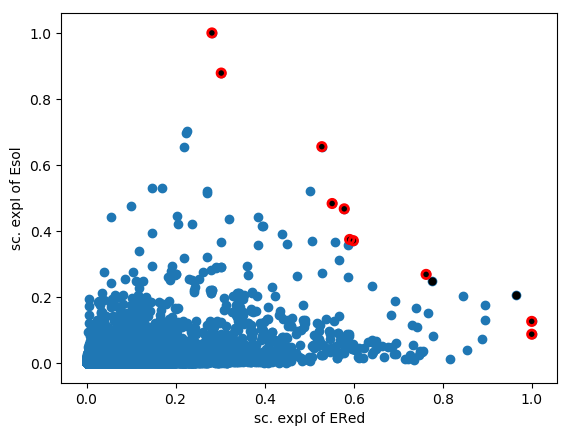

In [97]:
fig,(ax1)=plt.subplots(nrows=1,ncols=1)
ax1.scatter(expI[:,0],expI[:,1])
ax1.scatter(expIPR[:,0],expIPR[:,1],marker='o',lw=0, facecolors='black', edgecolors='k')
ax1.set_xlabel('sc. expI of ERed')
ax1.set_ylabel('sc. expI of Esol')
ax1.scatter(expI[prIdx][:,0],expI[prIdx][:,1],marker='o',lw=2, facecolors='none', edgecolors='r')

In [98]:
lxtrain = len(Xtrainsmi)
yt_predList_test = []
for i in range(nobj):
    yt_pred_test, tsigma_test = gprediction_pytorch(model=gpnetworkList[i],likelihood=gpnetwork_like_List[i], X_test=Xremain)
    yt_predList_test.append(yt_pred_test)
# yt_pred2, tsigma2 = gprediction_pytorch(model=model,likelihood=likelihood, X_test=Xtrain)
yt_pred_test=np.vstack((yt_predList_test)).T

print('Predicted values for new SMILES:')
print(115*'-')
print('{:<5s}{:<80s}{:<15s}{:<15s}'.format('ID','SMILES','Eox','Gsol'))
print(115*'-')
for i,a in enumerate(prIdx):
    print('{:<5d}{:<80s}{:<15f}{:<15f}'.format(lxtrain+i,Xremaininfo.SMILES.iloc[a],yt_pred_test[a][0],-yt_pred_test[a][1]))

Predicted values for new SMILES:
-------------------------------------------------------------------------------------------------------------------
ID   SMILES                                                                          Eox            Gsol           
-------------------------------------------------------------------------------------------------------------------
100  CS(=O)(=O)c1ccccc1-c1oc2cccc([N+](=O)[O-])c2c(=O)c1S(C)(=O)=O                   5.919901       -0.972770      
101  CS(=O)(=O)c1ccccc1-c1cc(=O)c2c(C[N+](=O)[O-])ccc(S(C)(=O)=O)c2o1                5.866773       -0.990300      
102  CS(=O)(=O)c1ccccc1-c1oc2c(C[N+](=O)[O-])cccc2c(=O)c1S(C)(=O)=O                  5.962227       -0.920042      
103  CS(=O)(=O)c1ccc(S(C)(=O)=O)c2c(=O)c([N+](=O)[O-])c(-c3ccccc3F)oc12              5.901730       -0.940691      
104  CS(=O)(=O)c1ccccc1-c1oc2c(S(C)(=O)=O)cccc2c(=O)c1S[N+](=O)[O-]                  5.939998       -0.940605      
105  CS(=O)(=O)c1ccccc1-c1oc2c(S(C)(=O)

newSMILES = 'CN(C)CCN(C)c1c(C(C)(C)C)c(N2CCCC2)c2nsnc2c1N(CCN(C)C)C(=O)Cc1ccccc1'
expimaxloc = Xremaininfo.decode().tolist().index(newSMILES)
print(expimaxloc)

if check new smiles already calc.

In [99]:
def check_in_done(smi):
    # df=pd.read_csv(r"C:\Users\jaina\Desktop\Flavonoid_withEli_win\Data\withQ12_\Q11_Q12_isoflavone_ydata.csv")
    df=pd.read_csv(r'./flav/flavone_ytrain_clean_60K_smi_pcs.csv')
    if smi in df.SMILES.to_list():
        return df.SMILES.to_list().index(smi)
    else:
        # print("mol not calculated before")
        return None

In [100]:
[check_in_done(smi=Xremaininfo.SMILES.iloc[smi]) for smi in prIdx ]

[None, None, None, None, None, None, None, None, None, None]

In [101]:
ytrain[ytrain.duplicated(subset="SMILES")]

,SMILES,delEsol,delEoxi


In [102]:
ytrain.drop_duplicates(subset="SMILES").shape

(100, 3)

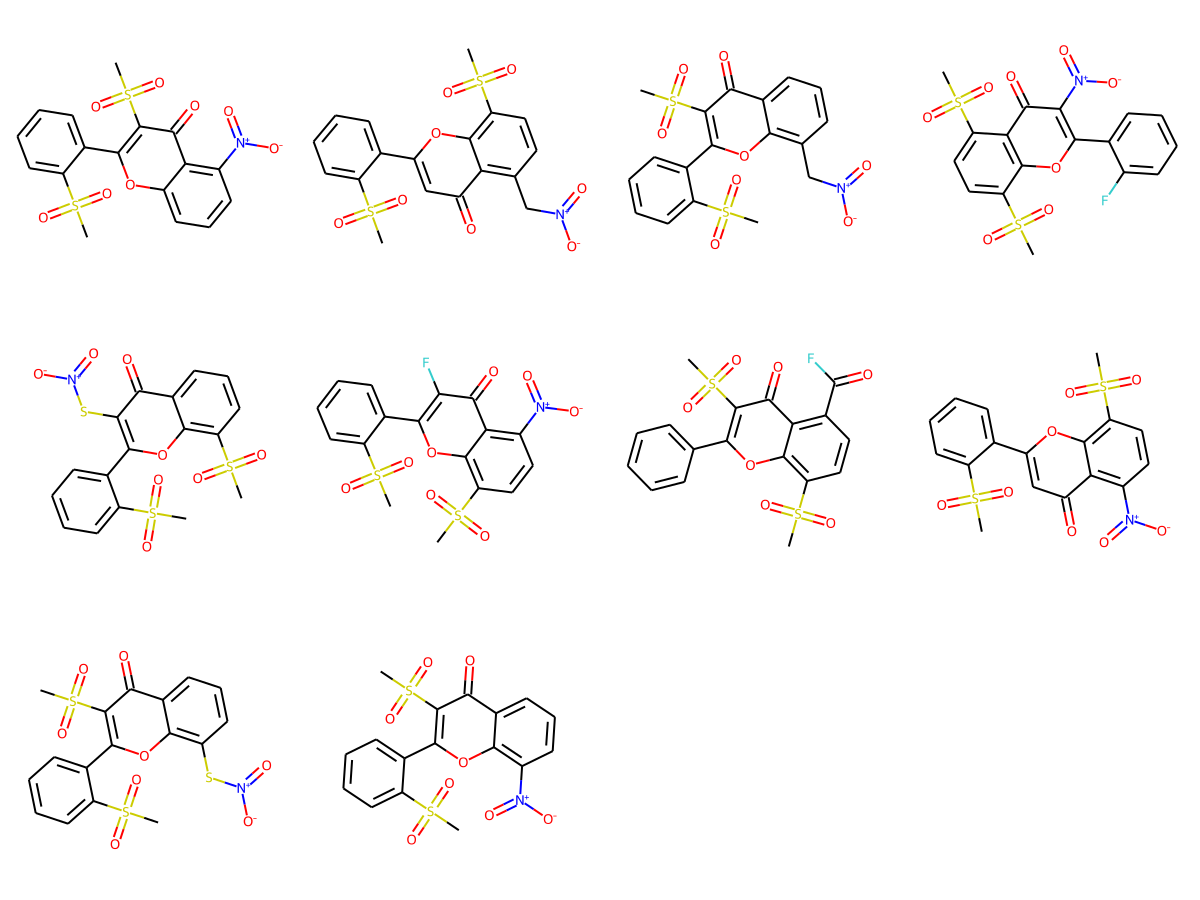

In [107]:
import datamol as dm
mols=[Chem.MolFromSmiles(Xremaininfo.SMILES.iloc[x]) for x in prIdx]
dm.to_image(mols)

In [108]:
import all_mbo_functions as myfn

In [109]:
Xtrain.shape[0]

100

In [110]:
def write_next_mol(save_mol=False,mols_smi=[]):
    if save_mol:
        file_num=Xtrain.shape[0]
        #Generate a g16 file for a new molecule
        ftext='ZA_Flavone_g16_neutral_p'
        myfn.smiles2dotcom(mols_smi,method="B3LYP", basis='6-31+G(d,p)',Freq=" ",sol=" scrf(cpcm,solvent=acetonitrile)  geom(Check) ", charge=0, mult=1, fileName=ftext+str(file_num))
        print(ftext+str(file_num))

        ftext='ZA_Flavone_g16_neutral_nosol_p'
        myfn.smiles2dotcom(mols_smi,method="B3LYP", basis='6-31+G(d,p)',Freq=" ",sol=" ", charge=0, mult=1, fileName=ftext+str(file_num))
        print(ftext+str(file_num))

        ftext='ZA_Flavone_g16_oxidized_p'
        myfn.smiles2dotcom(mols_smi,method="B3LYP", basis='6-31+G(d,p)',Freq=" ",sol=" scrf(cpcm,solvent=acetonitrile)  geom(Check) ", charge=1, mult=2, fileName=ftext+str(file_num))
        print('ZA_Flavone_g16_oxidized_p'+str(file_num))
    else:
        print("next mol not written in a .com file")

In [111]:
write_next_mol(save_mol=True,mols_smi=[Xremaininfo.SMILES.iloc[x] for x in prIdx])

Files generated in:  c:\Users\jaina\Box\Flavone
ZA_Flavone_g16_neutral_p100
Files generated in:  c:\Users\jaina\Box\Flavone
ZA_Flavone_g16_neutral_nosol_p100
Files generated in:  c:\Users\jaina\Box\Flavone
ZA_Flavone_g16_oxidized_p100


# Update the Xtrain file

In [112]:
def update_xtrain(flag=False):
    if flag:
        Xtrain_new=pd.concat([Xtrain,Xremain.iloc[prIdx]],ignore_index=True)
        Xtrainsmi_new=pd.concat([Xtrainsmi,Xremaininfo.iloc[prIdx]],ignore_index=True)
        # X=pd.read_csv(r'./flav/flavone_ytrain_clean_60K_smi_pcs.csv')
        Xtrain_new.to_csv(r'./flav/flavone_xtrain_clean_60K_pcs.csv',index=False)
        Xtrainsmi_new.to_csv(r'./flav/flavone_xtrain_clean_60K_smi_pcs.csv',index=False)
        print('updated Xtrain and Xtrainsmi')
    else:
        print('Xtrain and Xtrainsmi not updated')


In [113]:
update_xtrain(flag=True)

updated Xtrain and Xtrainsmi


In [114]:
def update_xtest(flag=False):
    if flag:
        Xtest_new=Xremain.drop(index=prIdx)
        Xtestsmi_new=Xremaininfo.drop(index=prIdx)

        Xtest_new.to_csv(r'./flav/flavone_xremain_clean_60K_pcs.csv',index=False)
        Xtestsmi_new.to_csv(r'./flav/flavone_xremain_smi_clean_60K_smi_pcs.csv',index=False)
        print('updated Xtest and Xtestsmi')
    else:
        print('Xtest and Xtestsmi not updated')


In [115]:
update_xtest(flag=True)

updated Xtest and Xtestsmi
